In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.xpu import device

from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
batch_size = 128
image_size = 64

# Creare dataset
garfield_comics_dataset = dset.ImageFolder(
    root="garfield_panels",
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Creare dataloader
train_dl = torch.utils.data.DataLoader(
    garfield_comics_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

len(train_dl)

250

In [4]:
len(garfield_comics_dataset)

32067

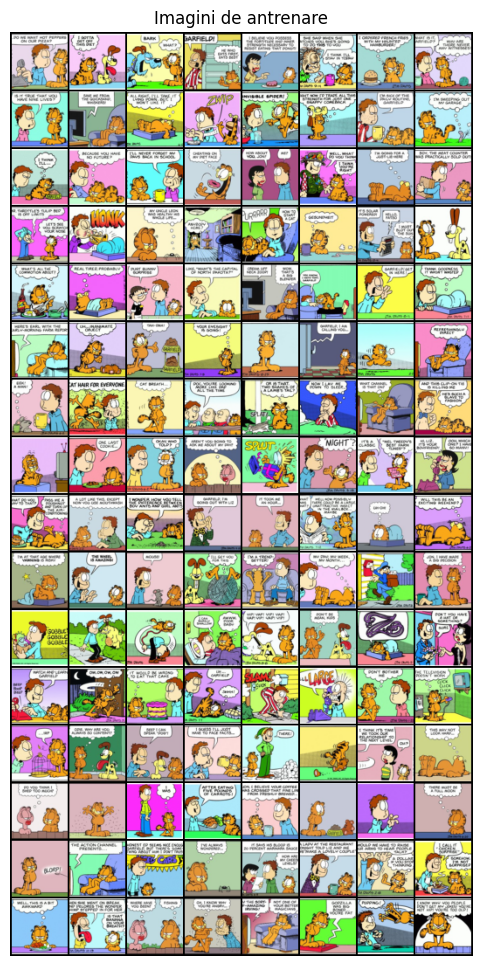

In [5]:
real_batch = next(iter(train_dl))

plt.figure(figsize=(20, 12))
plt.axis('off')

plt.title('Imagini de antrenare')
plt.imshow(
    np.transpose(
        make_grid(real_batch[0].to(device) ,padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)
plt.show()

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [7]:
# Numarul decanale in imaginile de antrenare, in cazul nostru avem imagini color nc = 3
nc = 3

# Marimea vector latent de intrare in Generator
nz = 100

# Dimensiunea hartii cu caracteristici (feature map) in Generator
ngf = 64

# Dimensiunea hartii cu caracteristici (feature map) in Discriminator
ndf = 64

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input z: vector de zgomot
            nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # dimensiune: (ngf * 8) x 4 x 4

            nn.ConvTranspose2d(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # dimensiune: (ngf * 4) x 8 x 8

            nn.ConvTranspose2d(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # dimensiune: (ngf * 2) * 16 * 16

            nn.ConvTranspose2d(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # dimensiune: (ngf) * 32 * 32

            nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
            # dimensiune: (nc) * 64 * 64
        )

    def forward(self, x):
        return self.main(x)

In [9]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input: (nc) x 64 x 64 (o imagine)
            nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # dimensiune: (ndf) x 32 x 32

            nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # dimensiune: (ndf * 2) x 16 x 16

            nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # dimensiune: (ndf * 4) x 8 x 8

            nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # dimensiune: (ndf * 8) x 4 x 4

            nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [11]:
nedD = Discriminator().to(device)
nedD.apply(weights_init)
print(nedD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Numarul de epoci
num_epochs = 100

In [13]:
# Initializam functia Loss BCE (Binary Cross Entropy)
criterion = nn.BCELoss()

# Lotul de vectori de zgomot latent ce for fi input-ul Generatorului
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Creem etichete pentru imagini reale si false
real_image_labels = torch.full((batch_size,), 1., dtype=torch.float, device=device)
fake_image_labels = torch.full((batch_size,), 0., dtype=torch.float, device=device)

# optimizator Adam
optimizer_d = optim.Adam(nedD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
def display(img):
    plt.figure(figsize=(6, 6))
    img = img / 2 + 0.5
    img = img.permute(1, 2, 0)
    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([]), plt.yticks([])
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


                Epoca: 1: Pas: 0     |
                Loss D_real: 0.4557    |  Loss D_fals: 0.2860 |
                Loss D_total : 0.7418 |  Loss G_total : 6.912 |
               Scor real : 0.736     |  Scor fals: 0.226
            


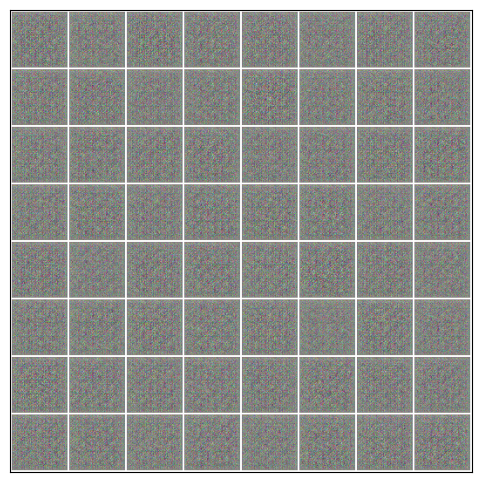


                Epoca: 1: Pas: 200     |
                Loss D_real: 0.2551    |  Loss D_fals: 0.0538 |
                Loss D_total : 0.3089 |  Loss G_total : 3.998 |
               Scor real : 0.835     |  Scor fals: 0.050
            


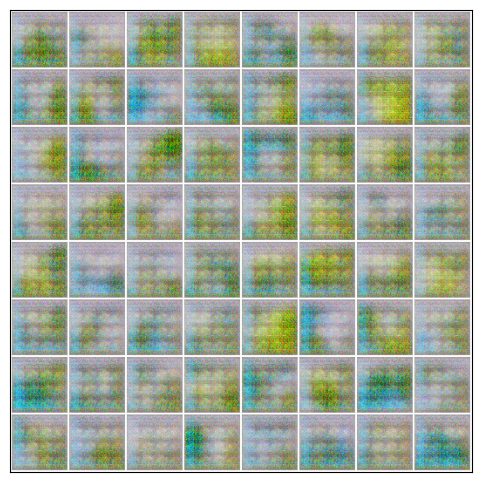

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x106282b80>
Traceback (most recent call last):
  File "/Users/vladlazar/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/vladlazar/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 936

KeyboardInterrupt: 

In [17]:
G_losses = []
D_losses = []

real_score_list = []
fake_score_list = []

for epoch in tqdm(range(num_epochs)):
    for i, (data, _) in enumerate(train_dl, 0):

        ###########################################################
        # Luam output-ul de la Discriminator si calculam Loss-urile
        ###########################################################
        nedD.zero_grad()
        real_images = data.to(device)

        # Trimitem imaginile reale in Discriminator
        output = nedD(real_images).view(-1)

        # Calculam Loss-ul imaginilor reale comparandu-le cu etichetele reale
        real_loss_D = criterion(output, real_image_labels)

        # Calculam gradientii pentru Discriminator
        real_loss_D.backward()

        real_score_D = output.mean().item()

        # Generam imagini false cu generatorul
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        # Clasificam imaginile false cu Discriminatorul
        output = nedD(fake_images.detach()).view(-1)

        # Calculam loss-ul pentru imaginile false
        fake_loss_D = criterion(output, fake_image_labels)

        # Insumam gradientii pentru imaginile false cu cele pentru imaginile reale
        fake_loss_D.backward()

        fake_score_D = output.mean().item()

        total_loss_D = real_loss_D + fake_loss_D

        # Adaptam parametrii
        optimizer_d.step()

        #######################################################
        # Luam output-ul de la Generator si calculam Loss-urile
        #######################################################

        netG.zero_grad()

        # Dam la Discriminator imagini false
        output = nedD(fake_images).view(-1)

        # Calculam Loss-ul Generatorului comparand imaginile false cu etichetele reale
        loss_G = criterion(output, real_image_labels)

        # Calculam gradientii
        loss_G.backward()

        # Adaptam parametrii
        optimizer_g.step()

        if i % 200 == 0 or ((epoch == num_epochs - 1) and (i == len(train_dl) - 1)):
            print(f"""
                Epoca: {epoch + 1}: Pas: {i}     |
                Loss D_real: {real_loss_D:.4f}    |  Loss D_fals: {fake_loss_D:.4f} |
                Loss D_total : {total_loss_D:.4f} |  Loss G_total : {loss_G:.3f} |
               Scor real : {real_score_D:.3f}     |  Scor fals: {fake_score_D:.3f}
            """)

            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                display(make_grid(fake, nrow=8, pad_value=1.0))

        G_losses.append(loss_G.item())
        D_losses.append(total_loss_D.item())

        real_score_list.append(real_score_D)
        fake_score_list.append(fake_score_D)








